Andrey Vagin

a.vagin@innopolis.university

# Imports and Constants

In [ ]:
import statistics
import numpy as np
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
from dateutil.parser import parse as parse_date

import sklearn
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

SEED = 42

# Data

In [ ]:
!ls

a1_dataset.csv	Intro_to_ML_Assigment_1__2022.pdf


In [ ]:
PATH = 'a1_dataset.csv'
df = pd.read_csv(PATH)

In [ ]:
df.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


In [ ]:
df['target'].value_counts()

0    466
1    459
Name: target, dtype: int64

Target is balanced very well. We do not know anything about dataset and what label of target is more important, so `accuracy` will be the best metric in our case.

In [ ]:
df.isna().sum()

target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64

As given in assignment description we need to handle 600 missing values in `var4` column.

In [ ]:
df.dtypes

target      int64
var1      float64
var2      float64
var3       object
var4      float64
var5      float64
var6       object
var7       object
dtype: object

We have 3 categorical columns to handle.

In [ ]:
num_cols = [
    'var1',
    'var2',
    'var4',
    'var5'
]

cat_cols = [
    'var3',
    'var6',
    'var7'
]

fetature_cols = num_cols + cat_cols

target_col = 'target'

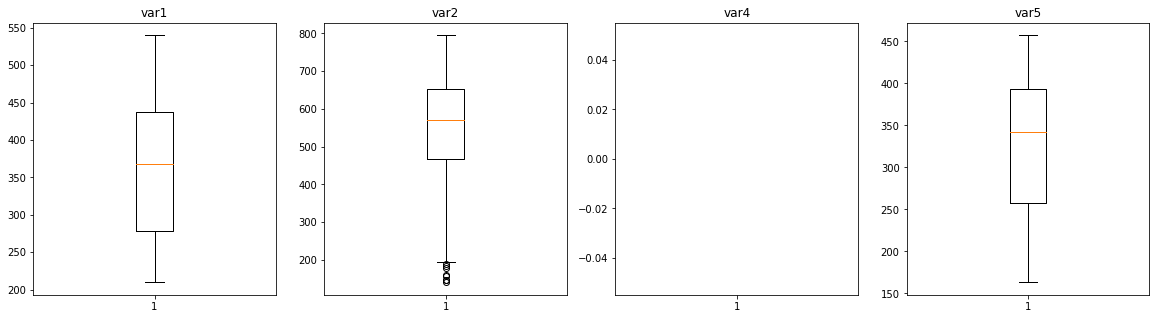

In [ ]:
fig = plt.figure(figsize=(20, 5))

# ax = ax.ravel()

for i, num in enumerate(num_cols):
    
    ax = fig.add_subplot(141 + i)
    ax.set_title(num)
    ax.boxplot(df[num])

plt.show()

As we can see there may be outlyers in the `var2` column.

And we have problems with knowing real distribution for `var4` column because of 600 missing values.

# Preprocessing

## Encoding categorical values

### `var3` column

In [ ]:
df['var3'].value_counts().reset_index()

,index,var3
0,Czech Republic,9
1,Greece,8
2,Senegal,8
3,Australia,8
4,South Africa,8
...,...,...
231,Jordan,1
232,Guadeloupe,1
233,Lesotho,1
234,Bermuda,1


In [ ]:
var3_cat_occur = df['var3'].value_counts().reset_index().groupby('var3').count()
var3_cat_occur

,index
var3,
1,16
2,40
3,37
4,56
5,49
6,23
7,10
8,4
9,1


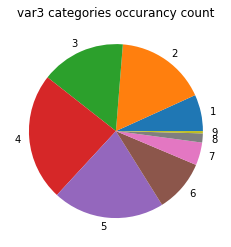

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('var3 categories occurancy count')
ax.pie(var3_cat_occur['index'], labels=var3_cat_occur.index)

plt.show()

As we can see we have 236 different categories in `var3` columns. Almost half of them has 1, 2 or 3 occurances in the table. We may have not enough data for these classes to extract some information for our model.

**Ordinal encoding** technique will not give us meaningful represenation for our data. We have 236 different categories. Such ecncoding will create big numeric difference between first and last classes but there is no such difference in location names. Ordinal encoding is not suitable for this column.

**One-hot encoding** techique in our case will give big growth in number of columns where information will be very sparse because we have a lot of classes and not that very big amount of data. I think that it will be better to drop this column but I will try to apply One-hot encoding first.

In [ ]:
var3_dummy = pd.get_dummies(df['var3'])
var3_dummy.head()

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antarctica (the territory South of 60 deg S),Antigua and Barbuda,Argentina,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### `var6` column

In [ ]:
df['var6'].value_counts()

yes    483
no     442
Name: var6, dtype: int64

In `var6` we are having only two categories. There is a good practice for linear regression usage to drop one of the categories to avoid collinearity in data columns. If we do so with One-hot encoding on binary data it will be equal to ordinal encoding.

In [ ]:
var6_encoded = df['var6'].apply(lambda x: 1. if x == 'yes' else 0.)
var6_encoded

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
920    1.0
921    0.0
922    1.0
923    1.0
924    1.0
Name: var6, Length: 925, dtype: float64

### `var7` column

In [ ]:
df['var7'].head()

0    2019-07-20 13:21:37
1    2019-04-04 21:30:46
2    2019-03-03 02:59:37
3    2019-03-19 08:00:58
4    2019-03-18 13:22:35
Name: var7, dtype: object

There are problematic values such as `2019-02-29 11:00:06`.

29-th of February in non leap year.

I will change such values to `2019-03-1 11:00:06` to make **dateutil** library methods work properly.


In [ ]:
bad_dates = [
    '2019-02-29 12:31:57', 
    '2019-02-29 11:00:06', 
    '2019-02-29 18:06:21',
    '2019-02-29 23:56:06',
    '2019-02-29 19:26:35']
    
df[df['var7'].isin(bad_dates)]

,target,var1,var2,var3,var4,var5,var6,var7
345,0,502.00,577.569,Angola,NaN,360.05,yes,2019-02-29 12:31:57
526,1,343.80,525.632,Guadeloupe,NaN,271.95,no,2019-02-29 18:06:21
632,0,463.08,516.361,Ireland,NaN,407.30,yes,2019-02-29 11:00:06
779,1,273.70,199.917,Madagascar,NaN,319.40,yes,2019-02-29 23:56:06
813,0,357.02,750.444,Barbados,NaN,381.00,yes,2019-02-29 19:26:35


In [ ]:
df.at[632, 'var7'] = '2019-03-1 11:00:06'
df.at[345, 'var7'] = '2019-03-1 12:31:5'
df.at[526, 'var7'] = '2019-03-1 18:06:21'
df.at[779, 'var7'] = '2019-03-1 23:56:06'
df.at[813, 'var7'] = '2019-03-1 19:26:35'

Let's check whether all theese dates belong to the same year

In [ ]:
check_year = lambda x: False if parse_date(x).year == 2019 else True
df['var7'].apply(check_year).sum()

0

All the dates are from 2019. I decided to convert all this dates into number of seconds which passed from the beginning of 2019.

In [ ]:
def convert_to_seconds(date):
    date = parse_date(date)

    days = 0
    for month in range(1, date.month):
        days += monthrange(2019, month)[1]
    days += date.day

    hours = days * 24 + date.hour

    minutes = hours * 60 + date.minute

    seconds = minutes * 60 + date.second

    return seconds

In [ ]:
df['var7'] = df['var7'].apply(convert_to_seconds)

Let's look at the result:

In [ ]:
df.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,17414497
1,0,446.06,666.182,Dominica,81.0,352.05,yes,8199046
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,5367577
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,6768058
4,0,453.08,600.156,Cameroon,105.0,422.95,no,6700955


## Data imputation for `var4`
At first we need to prepare data for training. We need to exract rows with non-empty `var4` colums and devide them into **train** and **test** datasets for crossvalidation.

In [ ]:
df['var4'].notnull().sum()

325

We have only 325 rows that is not null in `var4`.

In [ ]:
data = pd.concat([df[['target', 'var1', 'var2', 'var5', 'var7']], var6_encoded, var3_dummy], axis=1)
target = df['var4']

X = data[target.notnull()]
y = target[target.notnull()]

I think it makes sence to use polynomial fitures only for numeric columns.

In [ ]:
numeric_cols = ['var1', 'var2', 'var5']
other_cols = [col for col in data.columns if col not in numeric_cols]

In [ ]:
def train_pol_regr(X, y, degree=1):
    X = X.copy()
    y = y.copy()

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(X[numeric_cols])
    columns = poly.get_feature_names_out(numeric_cols)
    X_num = poly.transform(X[numeric_cols])
    X_num = pd.DataFrame(X_num, columns=columns)

    X = pd.concat([X_num, X[other_cols]], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    regr = LinearRegression()
    regr.fit(X_train, y_train)

    pred_train = regr.predict(X_train) 
    pred_test = regr.predict(X_test)

    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    mae_train = mean_absolute_error(y_train, pred_train)

    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    mae_test = mean_absolute_error(y_test, pred_test)

    return rmse_train, mae_train, rmse_test, mae_test

Let's look at the results.

In [ ]:
for degree in range(1, 5):
    rmse_train, mae_train, rmse_test, mae_test = train_pol_regr(X, y, degree=degree)
    print(f'Degree {degree}:')
    print(f'Train: rmse = {rmse_train}, mae = {mae_train}')
    print(f'Test: rmse = {rmse_test}, mae = {mae_test}\n')

Degree 1:
Train: rmse = 11.134367928691791, mae = 7.630305671407508
Test: rmse = 12310423716459.096, mae = 2156410919205.2695

Degree 2:
Train: rmse = 10.254880004989154, mae = 6.591564690900556
Test: rmse = 8753620474939.7295, mae = 1485735682449.421

Degree 3:
Train: rmse = 9.809901311558106, mae = 6.600118151986347
Test: rmse = 13432570282775.855, mae = 1474985300159.867

Degree 4:
Train: rmse = 9.659718739345706, mae = 6.460510059478005
Test: rmse = 17109743599406.277, mae = 2944528633769.079



Results on test a very bad, so I decied to drop One-hot features from `var3` column.

In [ ]:
data = pd.concat([df[['target', 'var1', 'var2', 'var5', 'var7']], var6_encoded], axis=1)
target = df['var4']

X = data[target.notnull()]
y = target[target.notnull()]

numeric_cols = ['var1', 'var2', 'var5']
other_cols = [col for col in data.columns if col not in num_cols]

for degree in range(1, 5):
    rmse_train, mae_train, rmse_test, mae_test = train_pol_regr(X, y, degree=degree)
    print(f'Degree {degree}:')
    print(f'Train: rmse = {rmse_train}, mae = {mae_train}')
    print(f'Test: rmse = {rmse_test}, mae = {mae_test}\n')

Degree 1:
Train: rmse = 13.818393207636362, mae = 8.369574857162656
Test: rmse = 12.90813146848636, mae = 8.072322085724108

Degree 2:
Train: rmse = 12.587808178644076, mae = 6.512451691851493
Test: rmse = 10.852984530731248, mae = 5.994320215292496

Degree 3:
Train: rmse = 12.084647437219074, mae = 7.138529044953033
Test: rmse = 11.052640968221166, mae = 6.757877292336309

Degree 4:
Train: rmse = 11.918159295179251, mae = 7.120857862046856
Test: rmse = 11.202535042611867, mae = 6.88109321146462



As we can see dropping of `var3` column gave us increase in quality.

With 4-th degree quality on test became worse. I will use 2-rd degree for data inputation.

In [ ]:
data = pd.concat([df[['target', 'var1', 'var2', 'var5', 'var7']], var6_encoded], axis=1)
var4 = df['var4']

poly = PolynomialFeatures(degree=2, include_bias=False)

poly.fit(data[numeric_cols])
columns = poly.get_feature_names_out(numeric_cols)
data_num = poly.transform(data[numeric_cols])
data_num = pd.DataFrame(data_num, columns=columns)

data = pd.concat([data_num, data[other_cols]], axis=1)

scaler = StandardScaler()
scaler.fit(data)

data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

X = data_scaled[var4.notnull()]
y = var4[var4.notnull()]

regr = LinearRegression()
regr.fit(X, y)

nulls = var4[var4.isnull()].index

for null_idx in nulls:
    var4.at[null_idx] = regr.predict([data_scaled.iloc[null_idx]])

Let's look at imputed data of `var4` column:

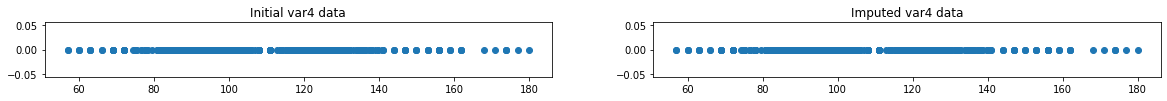

In [ ]:
fig = plt.figure(figsize=(20, 1))
ax1 = fig.add_subplot(121)
ax1.set_title('Initial var4 data')
ax1.scatter(y, np.zeros(y.shape))

ax2 = fig.add_subplot(122)
ax2.set_title('Imputed var4 data')
ax2.scatter(var4, np.zeros(var4.shape))

plt.show()

Distribution of imputed data lools like initial data it is good.

## Implementing PCA technique

In [676]:
data = pd.concat([df[['var1', 'var2', 'var5', 'var7']], var4, var6_encoded, var3_dummy], axis=1)
target = df['target']

In [ ]:
def apply_pca(data, dimensions):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    cov = np.cov(data_scaled.T)
    w, v = np.linalg.eig(cov)

    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:, idx]

    W = v[:, :dimensions]
    X = data_scaled @ W

    return X, W

Let's check whether my implementation works correct:

In [ ]:
apply_pca(data, 2)[0]

array([[-0.08187544,  1.16673612],
       [-1.31034986, -0.16794816],
       [ 0.10922415, -1.11354569],
       ...,
       [ 0.90323456,  0.76160146],
       [-0.87185972,  1.24202973],
       [ 0.63623955,  1.15547515]])

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
PCA(2).fit_transform(data_scaled)

array([[-0.08187544,  1.16710149],
       [-1.31034986, -0.16227722],
       [ 0.10922415, -1.11402896],
       ...,
       [ 0.90323456,  0.75769849],
       [-0.87185972,  1.24581565],
       [ 0.63623955,  1.1527317 ]])

My implementation of PCA gives the same result as PCA from **sklearn**.

/home/andrey/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


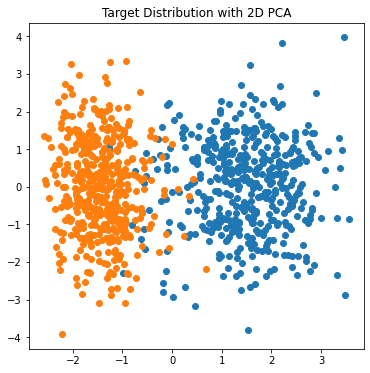

In [ ]:
X, _ = apply_pca(data, 2)

one = X[target[target == 1].index]
zero = X[target[target == 0].index]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('Target Distribution with 2D PCA')
ax.scatter(one[:, 0], one[:, 1])
ax.scatter(zero[:, 0], zero[:, 1])

plt.show()

As we can see our data is linearly separable in 2D projection.

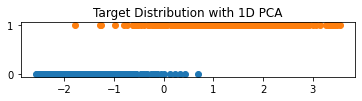

In [677]:
X, _ = apply_pca(data, 1)

one = X[target[target == 1].index]
zero = X[target[target == 0].index]

fig = plt.figure(figsize=(6, 1))
ax = fig.add_subplot(111)
ax.set_title('Target Distribution with 1D PCA')
ax.scatter(zero[:, 0], np.zeros(zero.shape[0]))
ax.scatter(one[:, 0], np.ones(one.shape[0]))

plt.show()

Projection to 1D do not give us good data separability

# Training
In this part I will use K-Fold Cross-Validation technique to tune best parameters for all the models on the train part of dataset. Then I will compare tuned models on the test dataset to choose which model performs the best.

In [673]:
X = pd.concat([df[['var1', 'var2', 'var5', 'var7']], var4, var6_encoded, var3_dummy], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# k for the K-Fold Cross-Validation
FOLDS_NUM = 3
pca_n_components = [1, 2, 3, 4, 5, 6, 7, 10, X.shape[1]]

In [648]:
def train_model(model, param_grid, X, y, k):
    estimator = Pipeline([
        ('std_scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', model)
    ])

    grid_search_clf = GridSearchCV(
        estimator=estimator,
        cv=k,
        scoring='accuracy',
        param_grid=param_grid
    )

    grid_search_clf.fit(X, y)

    return grid_search_clf

## Logistic Regression

In [674]:
param_grid_logisitc = [
    {'pca__n_components': pca_n_components,
    'model__penalty': ['none', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs']},

    {'pca__n_components': pca_n_components,
        'model__penalty': ['l2', 'l1'],
        'model__solver': ['liblinear']}
]

logistic = train_model(
    model=LogisticRegression(),
    param_grid=param_grid_logisitc,
    X=X_train, 
    y=y_train,
    k=FOLDS_NUM
)

print("Best parameters set found on development set:")
print(logistic.best_params_)

y_pred = logistic.predict(X_test)
logistic_acc = accuracy_score(y_test, y_pred)
print(f'\nTest accuracy: {logistic_acc}')

Best parameters set found on development set:
{'model__penalty': 'l1', 'model__solver': 'liblinear', 'pca__n_components': 242}

Test accuracy: 0.9837837837837838


Let's look at coefficients of our best model:

In [669]:
logistic_coefs = logistic.best_estimator_[2].coef_[0]

for col, coef in zip(X_train.columns, logistic_coefs):
    print(col, coef)

var1 4.998006654623992
var2 0.0
var5 -0.06488131086127225
var7 -0.619926004969721
var4 -0.37974396640543184
var6 0.05195001584201946
Afghanistan 0.0
Albania 0.0
Algeria 0.0
American Samoa 0.0
Andorra 0.0
Angola 0.0
Anguilla 0.0
Antarctica (the territory South of 60 deg S) 0.0
Antigua and Barbuda 0.0
Argentina 0.0
Armenia 0.0
Aruba 0.0
Australia -0.02544443784977539
Austria 0.09479518480819649
Azerbaijan -0.1465332448524817
Bahamas 0.0
Bahrain 0.0
Bangladesh 0.0
Barbados 0.6266640672679153
Belarus 0.0
Belgium 0.0
Belize 0.06428284536670668
Benin 0.0
Bermuda 0.0
Bhutan 0.0
Bolivia 0.3397042896637987
Bosnia and Herzegovina -0.23156116882169922
Bouvet Island (Bouvetoya) 0.0
Brazil 0.21023497645070094
British Indian Ocean Territory (Chagos Archipelago) 0.0
British Virgin Islands 0.0
Brunei Darussalam 0.0
Bulgaria 0.0
Burkina Faso 0.3952675765326579
Burundi -0.2030033907975543
Cambodia 0.0
Cameroon 0.13658754676588505
Canada 0.2251921461563322
Cape Verde 0.0
Cayman Islands 0.0
Central Africa

## KNN

In [ ]:
param_grid_knn = {
    'pca__n_components': pca_n_components,
    'model__n_neighbors': list(range(1, 11)),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine']
    }

knn = train_model(
    model=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    X=X_train, 
    y=y_train,
    k=FOLDS_NUM
)

print("Best parameters set found on development set:")
print(knn.best_params_)

y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
print(f'\nTest accuracy: {knn_acc}')

Best parameters set found on development set:
{'model__metric': 'cosine', 'model__n_neighbors': 10, 'model__weights': 'uniform', 'pca__n_components': 242}

Test accuracy: 0.9783783783783784


## Naive Bayes

In [ ]:
param_grid_naive_bayes = {
    'pca__n_components': pca_n_components
    }

naive_bayes = train_model(
    model=GaussianNB(),
    param_grid=param_grid_naive_bayes,
    X=X_train, 
    y=y_train,
    k=FOLDS_NUM
)

print("Best parameters set found on development set:")
print(naive_bayes.best_params_)

y_pred = naive_bayes.predict(X_test)
naive_bayes_acc = accuracy_score(y_test, y_pred)
print(f'\nTest accuracy: {naive_bayes_acc}')

Best parameters set found on development set:
{'pca__n_components': 6}

Test accuracy: 0.9405405405405406


# Conclusion
The best model is **Logistic Regression** with parameters:

`{'model__penalty': 'l1', 'model__solver': 'liblinear', 'pca__n_components': 242}`

Accuracy of this model is `0.9838`

At the beginning of the research I made a hypothesis that it would be better if not not to use the `var3` column at all. But both Linear Regression and CN performed the best with one-hot encoded `var3` column. The hypothesis was wrong.

The differnce between **Logistic Regression** and **KNN** is very small. I can not make clear conclusion which of this two models is the best.

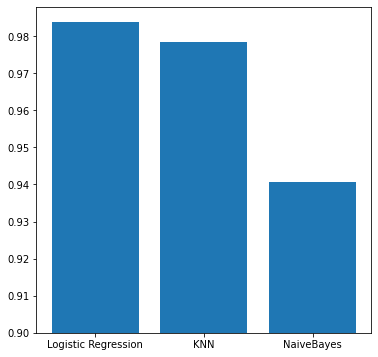

In [ ]:
bottom = 0.9
x = ['Logistic Regression', 'KNN', 'NaiveBayes']
y = np.array([logistic_acc, knn_acc, naive_bayes_acc]) - bottom

fig, ax = plt.subplots()

ax.bar(x, y, bottom=bottom)
fig.set_figwidth(6)
fig.set_figheight(6)

plt.show()